This notebook is dedicated to modeling data. All the data cleaning and exploratory data analysis, as well as the original data source, are attached in the previous notebooks.

#### Importing tools and libraries.

In [238]:
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.ticker as tick 
import seaborn as sns

plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import scale, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
#from sklearn.svm import SVC
from sklearn import svm
from sklearn.model_selection import GridSearchCV

#### Loading the dataframe: model_df from the model.csv file.

Reading the model_df from csv: it contains the Las Vegas restaurant info. Reasoning behind choosing Las Vegas as the sample space is illustrated in the EDA notebook in a greater detail. **TL;DR:** just seems sufficient.

In [154]:
model_df = pd.read_csv('yelp_dataset/model.csv').drop(['Unnamed: 0'],axis=1)

In [155]:
model_df.head(2)

,business_id,total_checkins,name,city,state,stars,review_count,attributes,categories,takes_cards,alcohol,quality
0,--9e1ONYQuAa-CB_Rrw7Tw,61780,Delmonico Steakhouse,Las Vegas,NV,4.0,1759,"{'Alcohol': ""'full_bar'"", 'BusinessParking': ""...","Seafood, Cajun/Creole, Restaurants, Steakhouses",True,True,good
1,-0RkJ_uIduNLWQrphbADRw,3799,Rooster Boy Cafe,Las Vegas,NV,4.0,194,"{'WheelchairAccessible': 'True', 'RestaurantsP...","Coffee & Tea, Restaurants, Cafes, Food, Breakf...",True,False,good


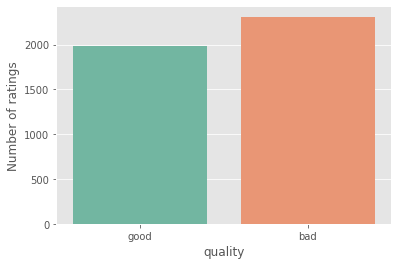

In [156]:
sns.countplot(x ='quality', data = model_df, palette = 'Set2') 
plt.ylabel("Number of ratings")
plt.show;

There appears to be a close tie. We want to pick one feature to start that separates the two cases. The pairplot diagonal will help guide us towards a covariate that separates the data well.

## Features

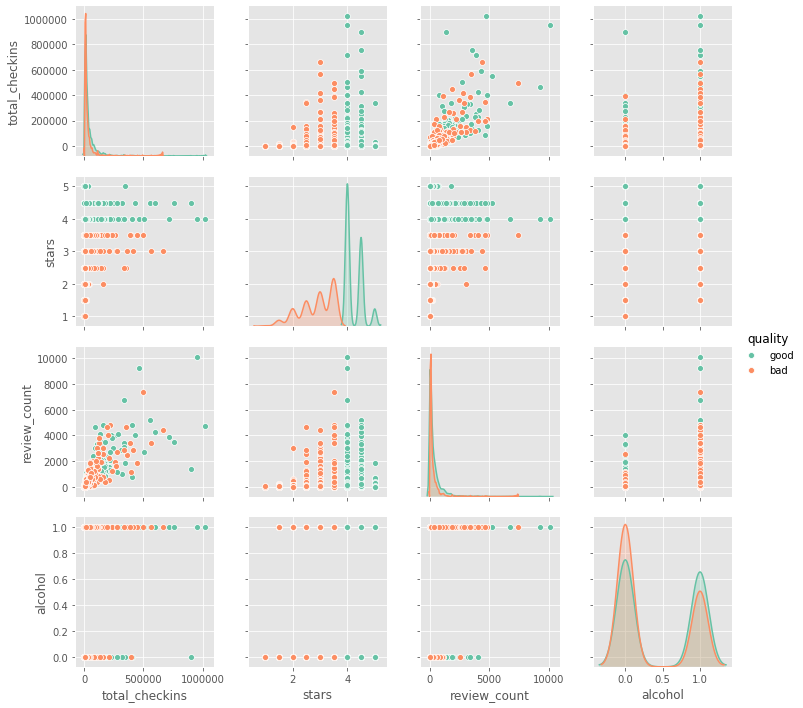

In [158]:
sns.pairplot(model_df, hue='quality', palette = "Set2");

* By looking at the pairplot above, we can clearly see that people tend to be frequenting the places with good star reviews more often. Also, people seem to be favoring places that serve alcohol, based on the foot traffic.

* Turns out, takes_cards parameter got saved as a string rather than a boolean value, and this is why it didn't show up on the pairplot. Those values need to be adjusted.

In [159]:
model_df['takes_cards'].unique()

array(['True', 'False', 'None'], dtype=object)

In [160]:
swap = {'None': False, 'False': False, 'True': True}
model_df['takes_cards'] = model_df['takes_cards'].map(swap)

In [192]:
model_df

,business_id,total_checkins,name,city,state,stars,review_count,attributes,categories,takes_cards,alcohol,quality
0,--9e1ONYQuAa-CB_Rrw7Tw,61780,Delmonico Steakhouse,Las Vegas,NV,4.0,1759,"{'Alcohol': ""'full_bar'"", 'BusinessParking': ""...","Seafood, Cajun/Creole, Restaurants, Steakhouses",True,True,good
1,-0RkJ_uIduNLWQrphbADRw,3799,Rooster Boy Cafe,Las Vegas,NV,4.0,194,"{'WheelchairAccessible': 'True', 'RestaurantsP...","Coffee & Tea, Restaurants, Cafes, Food, Breakf...",True,False,good
2,-1m9o3vGRA8IBPNvNqKLmA,11107,Bavette's Steakhouse & Bar,Las Vegas,NV,4.5,493,"{'RestaurantsTakeOut': 'False', 'WiFi': ""u'fre...","Bars, African, Cocktail Bars, American (New), ...",True,True,good
3,-2nfJ8yK54A7Md2RzmMR4g,82,Louie Louie Hibachi & Sushi On The Road,Las Vegas,NV,5.0,8,"{'Caters': 'True', 'RestaurantsTableService': ...","Food Trucks, Japanese, Food, Sushi Bars, Resta...",True,False,good
4,-3cJ2k_iwauMpy1WfI4NrA,2938,Pho4Real,Las Vegas,NV,4.5,159,"{'NoiseLevel': ""u'average'"", 'Ambience': ""{'to...","Vietnamese, Noodles, Soup, Restaurants",True,False,good
...,...,...,...,...,...,...,...,...,...,...,...,...
4293,zrMpy_uQ5_77YapMkp8lUA,1258,Asada's Tacos,Las Vegas,NV,3.0,22,"{'NoiseLevel': ""u'average'"", 'RestaurantsAttir...","Mexican, Restaurants",True,False,bad
4294,zsQk990PubOHjr1YcLkQFw,17281,Dakao Sandwiches,Las Vegas,NV,4.0,252,"{'BikeParking': 'True', 'RestaurantsReservatio...","Food, Bakeries, Sandwiches, Vietnamese, Restau...",True,False,good
4295,ztIaKXWOuWcRf7GJo9-fWQ,6487,Adventure Indoor Playground,Las Vegas,NV,4.0,132,"{'ByAppointmentOnly': 'False', 'WheelchairAcce...","Party & Event Planning, Event Planning & Servi...",True,True,good
4296,zuwba6QEBIDZT0tJZmNhdQ,10036,Kobe Sushi Bar,Las Vegas,NV,3.5,359,"{'NoiseLevel': ""u'average'"", 'RestaurantsGoodF...","Tapas Bars, Restaurants, Japanese, Sushi Bars",True,True,bad


In [194]:
model_df.shape

(4298, 12)

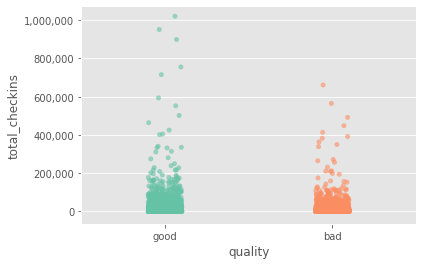

In [148]:
ax = sns.stripplot(x='quality',y='total_checkins', jitter=True,data=model_df,alpha=0.6, palette = "Set2")
ax.get_yaxis().set_major_formatter(tick.FuncFormatter(lambda x, p: format(int(x), ',')));

#### Feature assignment

In [164]:
feature_names = ['review_count', 'total_checkins', 'takes_cards', 'alcohol']
X = model_df[feature_names]
y = model_df['quality']

#### Separating training from testing data. Scaling.

In [165]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [166]:
scaler = MinMaxScaler()

In [167]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Modeling

##  1) Logistic Regression

logreg = LogisticRegression(solver = 'lbfgs')

In [169]:
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

The output observed above is a string representation of the fitted model.
Now, we can evaluate the model's performance:

In [170]:
logreg.predict_proba(X)

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [171]:
logreg.score(X_test, y_test)

0.5837209302325581

In [172]:
confusion_matrix(y_test, logreg.predict(X_test))

array([[350, 125],
       [233, 152]])

As we can tell, this model didn't turn out to be very accurate. <br>
Let's take a look at the **confusion matrix**: <br>
 - **350** true positive predictions, **125** false positive predictions
 - **233** false negatives, **152** true negatives. <br>
 
Also, binary classifiers aren't always ideal when we're looking for good food...

In [173]:
print(classification_report(y, logreg.predict(X)))

              precision    recall  f1-score   support

         bad       0.00      0.00      0.00      2311
        good       0.46      1.00      0.63      1987

    accuracy                           0.46      4298
   macro avg       0.23      0.50      0.32      4298
weighted avg       0.21      0.46      0.29      4298



/Users/sasha_prokhorova/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Not too hot....

## 2) KNN

In [174]:
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [175]:
y_pred = classifier.predict(X_test)

In [176]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[320 155]
 [168 217]]
              precision    recall  f1-score   support

         bad       0.66      0.67      0.66       475
        good       0.58      0.56      0.57       385

    accuracy                           0.62       860
   macro avg       0.62      0.62      0.62       860
weighted avg       0.62      0.62      0.62       860



In [177]:
error = []

# Calculating error for K values between 1 and 40
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

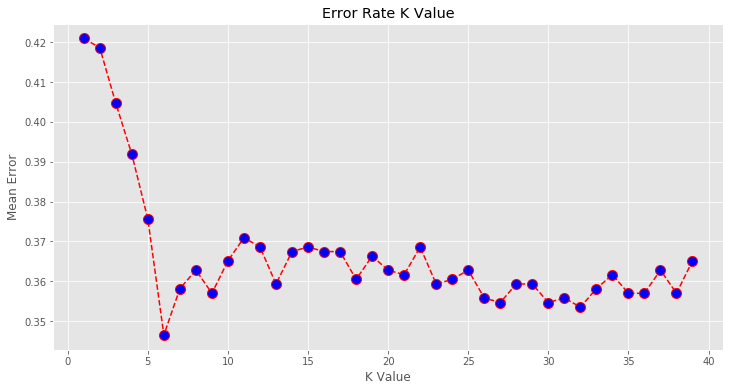

In [178]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error');

According to the graph above, this will work best with 6 nearest neighbors casting the vote.

In [179]:
classifier = KNeighborsClassifier(n_neighbors=6)
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                     weights='uniform')

In [180]:
y_pred = classifier.predict(X_test)

In [181]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[369 106]
 [192 193]]
              precision    recall  f1-score   support

         bad       0.66      0.78      0.71       475
        good       0.65      0.50      0.56       385

    accuracy                           0.65       860
   macro avg       0.65      0.64      0.64       860
weighted avg       0.65      0.65      0.65       860



KNN did slightly better than the others.

## 3) SVM

Note: the code for this exercise is borrowed from @jasontdean

What if we experimented with the star classification scale?

In [233]:
svm_df = model_df.copy()
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for column_name in svm_df.columns:
    if svm_df[column_name].dtype == object:
         svm_df[column_name] = le.fit_transform(svm_df[column_name])
    else:
         pass

In [234]:
# remove restaurants that have between 3 and 4 stars

svm_df = svm_df.drop(svm_df[(svm_df['stars'] < 4) & (svm_df['stars'] > 3)].index)
svm_df = svm_df.reset_index(drop=True)

# if a restaurant has 4 stars or greater, assign it a value of 1, otherwise 0
for i in range(0,len(svm_df)):
    if svm_df['stars'][i] >= 4:
        svm_df.set_value(i,'stars',1)
    else: 
        svm_df.set_value(i,'stars',0)

print("Number of restaurats classified as greater than or equal to 4 stars (1):  ",
      len(svm_df[(svm_df['stars'] > 0)]))

print("Number of restaurats classified as less than or equal to 3 stars (0):  ",
      len(svm_df[(svm_df['stars'] == 0)]))

Number of restaurats classified as greater than or equal to 4 stars (1):   1987
Number of restaurats classified as less than or equal to 3 stars (0):   1470


/Users/sasha_prokhorova/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if __name__ == '__main__':
/Users/sasha_prokhorova/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # This is added back by InteractiveShellApp.init_path()


In [195]:
svm_df.shape

(3457, 12)

In [200]:
svm_df.columns

Index(['business_id', 'total_checkins', 'name', 'city', 'state', 'stars',
       'review_count', 'attributes', 'categories', 'takes_cards', 'alcohol',
       'quality'],
      dtype='object')

In [236]:
# split the data into test and training sets and scale
split = np.random.rand(len(svm_df)) < 0.7
svm_train = svm_df[split]
svm_train_features = svm_train.drop(['stars'], axis=1)
svm_train_labels = svm_train['stars']

# scale the training data
scaler = StandardScaler()
svm_train_scaled = scaler.fit_transform(svm_train_features)

# process the test data
svm_test = svm_df[~split]
svm_test_features = svm_test.drop(['stars'], axis=1)
svm_test_labels = svm_test['stars']

#scale the test data
svm_test_scaled = scaler.transform(svm_test_features)

We will next perform hyperparameter tuning using GridSearchCV. We will consider one kernel (rbf) and evaluate three different values of 'C' for each kernel. The rbf kernel also contains an additional hyperparameter, gamma. Note we will also use 10 fold cross validation across the test data set.

In [239]:
# define hyperparameter grid and tuning via gridsearch
parameter_candidates = [
  {'C': [100, 1000, 10000], 'gamma': [0.01, 0.001, 0.0001], 'kernel': ['rbf']},
]

svr = svm.SVC()
clf = GridSearchCV(svr, parameter_candidates, n_jobs=1, cv=10)
clf.fit(svm_train_features, svm_train_labels)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=1,
             param_grid=[{'C': [100, 1000, 10000],
                          'gamma': [0.01, 0.001, 0.0001], 'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [240]:
# find the best hyperparameter values from tuning
print('Best C:',clf.best_estimator_.C)
print('Best Kernel:',clf.best_estimator_.kernel)
print('Best Gamma:',clf.best_estimator_.gamma)

Best C: 100
Best Kernel: rbf
Best Gamma: 0.01


In [241]:
# We can now build a SVM model using the optimal values for the hyperparameters.

SVMmodel = svm.SVC(kernel='rbf', C=10000, gamma=.001) 
SVMmodel.fit(svm_train_scaled, svm_train_labels)
SVMmodel.score(svm_test_scaled, svm_test_labels)

1.0

In [242]:
resPredict = SVMmodel.predict(svm_test_scaled)
preds = pd.DataFrame(confusion_matrix(svm_test_labels, resPredict))
preds.columns = ['Predicted < 3 Stars', 'Predicted > 4 Stars']
preds.index = ['Actual < 3 Stars', 'Actual > 4 Stars']
preds

,Predicted < 3 Stars,Predicted > 4 Stars
Actual < 3 Stars,440,0
Actual > 4 Stars,0,573


The model performed too well. Some investigation must be done.

**Reminder:** Borrowed code.

## 4) Random Forest

In [202]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

In [203]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6209302325581395


In [211]:
feature_imp = pd.Series(clf.feature_importances_, index = feature_names)
feature_imp

review_count      0.476392
total_checkins    0.488126
takes_cards       0.012595
alcohol           0.022887
dtype: float64

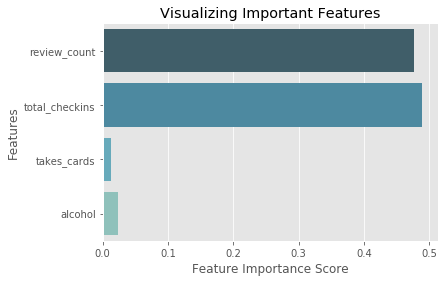

In [219]:
sns.barplot(x=feature_imp, y=feature_names, palette = "GnBu_d")
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

* Now, let's see if the model will have improved performance if we eliminate "useless" features:

In [226]:
X = model_df[['review_count', 'total_checkins']]  # Removed feature "'takes_cards' and 'alcohol'"
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

In [227]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

In [228]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.608139534883721


In [229]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[308 157]
 [180 215]]
              precision    recall  f1-score   support

         bad       0.63      0.66      0.65       465
        good       0.58      0.54      0.56       395

    accuracy                           0.61       860
   macro avg       0.60      0.60      0.60       860
weighted avg       0.61      0.61      0.61       860



Model performed slightly worse...

Note to self: for the future work, take a deeper dive into the attributes - model needs more features.